# Apple Stock Price Prediction with LSTM model

In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import date
import math

import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
START = '2015-01-01'
END = date.today().strftime("%Y-%m-%d")

<h4>Load Apple stock data into a dataframe

In [3]:
df_AAPL = web.DataReader('AAPL', data_source='yahoo', start=START, end=END)

<h4>Exploring dataset

In [4]:
df_AAPL.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,27.860001,26.837500,27.8475,27.332500,212818400.0,24.941502
2015-01-05,27.162500,26.352501,27.0725,26.562500,257142000.0,24.238857
2015-01-06,26.857500,26.157499,26.6350,26.565001,263188400.0,24.241146


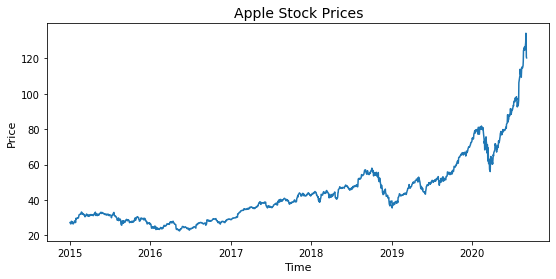

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.plot(df_AAPL['Close'])
plt.title('Apple Stock Prices', fontsize=14)
plt.xlabel('Time', fontsize=11)
plt.ylabel('Price', fontsize=11)
plt.show()

<h3>Forecast Stock Price

In [6]:
data = df_AAPL.filter(['Close'])
data.shape

(1430, 1)

In [7]:
# Difine the size of the samples
TRAIN_SIZE = math.trunc(data.shape[0] * .9)
TEST_SIZE = data.shape[0] - TRAIN_SIZE

<h4>Split data into train and test

In [8]:
train = data.iloc[0:TRAIN_SIZE,:]
test = data.iloc[TRAIN_SIZE:len(data),:]

x_train = np.array(range(TRAIN_SIZE))
x_test = np.array(range(TRAIN_SIZE, len(data)))

<h4>MSE (mean square error)

In [9]:
def mse(y_true, y_pred):
    return round(((y_true - y_pred) ** 2).sum() / y_true.size, 2)

<h4>MAPE (Mean Absolute Percentage Error)

In [10]:
def mape(y_true, y_pred):
    return round(100*(np.abs(y_true - y_pred) / y_true).sum() / y_true.size, 2)

<h3>Applying LSTM model

<h4>Prepare train data to use in the LSTM model

In [11]:
# Split train sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
# Converting the dataframe to a numpy array
dataset = data.values

# timeseries = train['Close'].values
n_steps = 15
n_features = 1

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [14]:
# Create the scaled training data set 
train_data = scaled_data[0:TRAIN_SIZE, : ]

In [15]:
# Split data into X and y
x_train, y_train = split_sequence(train_data, n_steps)

In [16]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
# Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))

<h4>Vanilla LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# define model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, n_features)))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mse')

In [19]:
# fit model
lstm_model.fit(x_train, y_train, epochs=100, verbose=0)

<h4>Test prediction

In [20]:
# Test dataset
test_data = scaled_data[TRAIN_SIZE - n_steps: , : ]

In [21]:
# Split test dataset
x_test, y_test = split_sequence(test_data, n_steps)

In [22]:
# Convert x_test to a numpy array 
x_test = np.array(x_test)

In [23]:
# Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))

In [24]:
# Getting the models predicted price values
predictions = lstm_model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) # Undo scaling

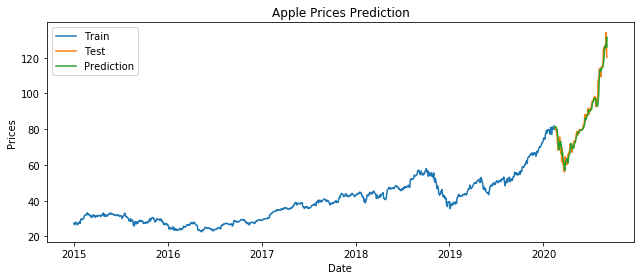

In [25]:
# Plot/Create the data for the graph
train = data[:TRAIN_SIZE]
test = data[TRAIN_SIZE:]
test['Predictions'] = predictions

# Visualize the data
fig, ax = plt.subplots(1,1, figsize=(9, 4))
ax.plot(train['Close'], label='Train')
ax.plot(test['Close'], label='Test')
ax.plot(test['Predictions'], label='Prediction')
plt.title('Apple Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend(loc='best')
plt.tight_layout()

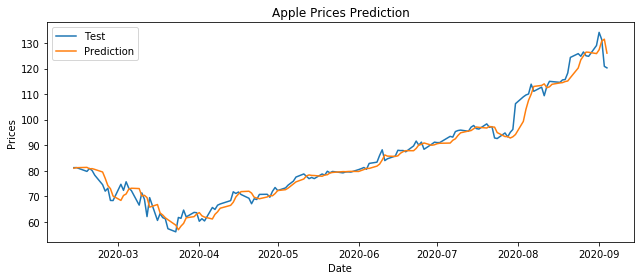

In [26]:
# Plot/Create the data for the graph
test = data[TRAIN_SIZE:]
test['Predictions'] = predictions

# Visualize the data
fig, ax = plt.subplots(1,1, figsize=(9, 4))
ax.plot(test['Close'], label='Test')
ax.plot(test['Predictions'], label='Prediction')
plt.title('Apple Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend(loc='best')
plt.tight_layout()

In [27]:
MSE_error = mse(test['Close'], test['Predictions'])
MAPE_error = mape(test['Close'], test['Predictions'])

print('Apple Mean Squared Error is {}'.format(MSE_error))
print('Apple Mean Absolute Percentage Error is {}'.format(MAPE_error))

Apple Mean Squared Error is 9.06
Apple Mean Absolute Percentage Error is 2.52


In [28]:
def lstm(neurons, x_train, y_train):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=neurons, activation='relu', input_shape=(n_steps, n_features)))
    lstm_model.add(Dense(units=1))
    lstm_model.compile(optimizer='adam', loss='mse')
    
    lstm_model.fit(x_train, y_train, epochs=100, verbose=0)
    
    test_data = scaled_data[TRAIN_SIZE - n_steps: , : ]
    x_test, y_test = split_sequence(test_data, n_steps)
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))
    predictions = lstm_model.predict(x_test) 
    predictions = scaler.inverse_transform(predictions)
    MSE_error = mse(test['Close'], test['Predictions'])
    
    return MSE_error

In [29]:
results = []
for i in (60, 80, 100):
    results.append(lstm(i, x_train, y_train))
results

[9.06, 9.06, 9.06]

In [30]:
lstm(100, x_train, y_train)

9.06